In [ ]:
# default_exp primitives

# Primitives

> Implementations for vertex, graph, and cell monolayer

In [ ]:
#hide
from nbdev.showdoc import *

- Graph primitives:
    - `Vertex`: implements a vertex object. Stores position of a given vertex (or vertices) as `1x2` `torch.tensor`, and implements methods for interacting with `torch` autograd. Compatible with D-dimensional `NxD` `torch.tensor`.
    - `Graph`: implements graph object. Stores vertices (`Vertex` object with `NxD` `torch.tensor`), edges (`Nx2` integer array of vertex indices) connecting the vertices, and implements methods for interacting with `torch` autograd.
- Cell monolayer representations: 
    - `Monolayer`: Implements cell monolayer, such as (2-dimensional) apical plane of an epithelial tissue. Inherits from `Graph` class. [__needs docs__]
        - `Graph` and `Monolayer` will need "to", "dtype", and "device" methods.

In [ ]:
#export
import torch
import numpy as np

## Graph primitives

### Vertex object

In [ ]:
#export
class Vertex(object):
    '''Implements vertex and stores vertex position(s) as Nx2 (or any 2-D tensor) `torch.Tensor`:(x,y,...)'s.
    Rows represent points, columns the spatial dimensions, i.e. `[[x1,y1], [x2,y2], ...,[xN,yN]]`
    
    - Methods:
        - `dist(self,other)` : calculates Euclidean distance between two points (each row).
        - `zero_grad_(self)` : set all gradients to zero (used during gradient descent at each iter-n step).
        - `grad(self)` : get gradient w.r.t. each tensor in `self.x`
        - `requires_grad_(self,val)`: sets `torch.tensor` flag inplace
        - `requires_grad(self)`: returns `torch.tensor` flag
    - Properties :
        - `x` : use it to set/get location torch.tensor (returns or modifies self._x)
    '''
    def __init__(self,location=None,**kwargs):
        '''`location` must be (or convertible to)  2D `torch.tensor` w/ float dtype, set and get `location` with self.x
        
        Usage:
        `v = Vertex(torch.tensor([[3.,-1.]],requires_grad=True,dtype=torch.float64))`
        '''
        if location is not None:
            if type(location) is list:
                location = torch.tensor(location,**kwargs)
            elif type(location) is np.ndarray:
                location = torch.from_numpy(location)
            assert location.ndim==2, f"Input 'location' has wrong dimensions, location.ndim!=2 :'( "
        self._x=location
    
    def dist(self,other):
        ''' Calculate (Euclidean) distance to another vertex from self._x.'''
        return torch.norm(other.x - self._x,dim=1,p=2,keepdim=True)
    
    def zero_grad_(self):
        '''set gradients to zero if x.requires_grad==True'''
        if self._x.grad is not None:
            self._x.grad.data.zero_()
    
    def grad(self):
        '''Get accumulated gradients w.r.t. x (calculated with backprop; `torch.autograd`)'''
        return self._x.grad
    
    def requires_grad_(self,val):
        '''Access to `torch.tensor` method to change `requires_grad` status'''
        self._x.requires_grad_(val)
        
    def requires_grad(self):
        '''Access to `torch.tensor` method to view `requires_grad` status'''
        return self._x.requires_grad
    
    def device(self):
        """Returns torch tensor's device"""
        return self.x.device
    def to_(self,val):
        """Change torch tensor's device"""
        self._x = self.x.to(val)
    
    def dtype(self):
        """Returns torch tensor's dtype"""
        return self.x.dtype
    
    @property
    def x(self):
        return self._x
    @x.setter
    def x(self, val):
        self._x = val
    
    def __str__(self):
        return f"{self._x}"
    def __repr__(self):
        return f"Vertex {self._x}; dtype:{self._x.dtype}"
    

Initialization, and calculating distances between vertices:
- When you initialize vertices with no input `v = Vertex()`, the location `v.x` is set to `None`.
- `Vertex(location)` accepts `torch.tensors`, list of lists that are convertible to tensors (with optional keyword arg-s for `torch.tensor()`), numpy.ndarrays (using `torch.from_numpy()`)
- `v.x` (i.e. location for `v=Vertex(location)`) is assumed to be Nx2 array (or any 2D array), and sizes are __not__ checked when set using `self.x`.

In [ ]:
# Define vertices with Nx2 torch tensors
o=Vertex()
o.x=torch.tensor([0.,0.]) # set to 0's (origin)
# or with location at init
v1=Vertex([[1.,1.]],dtype=torch.float32)
# calculate distance between vertices
r = o.dist(v1)
print(f"Distance between two vertices (o <--> v1) : {r.numpy().squeeze()}")

Distance between two vertices (o <--> v1) : 1.4142135381698608


Computing and resetting gradients:
- Example below demonstrates computing $\partial y/\partial v_{i,j}$ for $y = \sum_i\sum_j v_{i,j}^2$ using `torch.autograd`

In [ ]:
v = Vertex([[3.,-1.],[0.1,0.]],requires_grad=True,dtype=torch.float32)
# do some calculation with v.x
y = torch.sum(v.x**2)
# calculate grad-s
y.backward()
print('dy/dx_i after y.backward():\n',v.grad())
# set grad-s to zeros (useful when you don't want to accumulate grad-s)
v.zero_grad_()
print('dy/dx_i after zeroing grad-s:\n',v.grad())

dy/dx_i after y.backward():
 tensor([[ 6.0000, -2.0000],
        [ 0.2000,  0.0000]])
dy/dx_i after zeroing grad-s:
 tensor([[0., 0.],
        [0., 0.]])


### Vertex usage example
<a name="ex1">Trapped particle in a 2D fluid</a>

Let's assume linear drag, where force exerted by a spring is proportional to the velocity of the particle (drag force is $F_d=-b\frac{dx(t')}{dt'}$)
$$F_s(t') = -\nabla U = b\frac{dx(t')}{dt'}$$
where $U$ is the potential energy of the spring (e.g. optical trap) $U=k\cdot |r|^2$, where $r$ is the vector from equilibrium point, $o$, pointing to the current location of the particle, $x$. After re-defining time ($t'$) as a relative "scaled" time $t=\frac{t'}{b}$ and taking gradient of potential energy w.r.t. $x$, we can re-write the equation of motion (also let's set $o$ as origin $[0,0]$, then $r=x$)
$$\frac{dx(t)}{dt}=-2k(x-o)= -2kx$$
Let's numerically solve this equation ( _refer to the code cell below_ ). If the scale of the step size is chosen well (e.g. in the code below for large `k` use smaller `Dt`), solution $x(t)$ should converge to the equilibrium point $o$.

In [ ]:
#hide
import matplotlib.pylab as plt, numpy as np
from mpl_toolkits.mplot3d import axes3d

One way to model this system is to use two vertices, one for constant equilibrium point $o$, and a second vertex for particle position $x(t)$. To track potential energy gradient w.r.t. $x(t)$ we'll set `requires_grad=True` for the moving vertex, `v1` in the code below (this flag enables `torch`'s autograd to backpropagate the gradients).

In [ ]:
o  = Vertex(torch.tensor([[0,0]],dtype=torch.float64)) # equilibrium point (where U(x) is minimum)
v1 = Vertex(torch.tensor([[-3,3]],requires_grad=True,dtype=torch.float64)) # particles location
r = o.dist(v1)
print(f'distance from equilibrium (r):{r.item():.4f}')
print(f'o requires_grad? :{o.requires_grad()}',
      f'\nv1 requires_grad?:{v1.requires_grad()}',
      f'\nr requires_grad? :{r.requires_grad}')
# note that for Vertex self.requires_grad() is a function

distance from equilibrium (r):4.2426
o requires_grad? :False 
v1 requires_grad?:True 
r requires_grad? :True


In order to calculate gradients w.r.t. $x$, we need to set up a function that maps $x$ to some scalar value. In our example, this function is the potential energy function $U(x)$ (`energy(r)` below). Once `energy` function is evalutated, we need to call `backward()` on the returned `torch.tensor` to calculate (analytic) gradient of potential energy function at $x=v1$ (i.e. $\nabla_x U|_{x=v1}$; `dEdx` in code below)

In [ ]:
# Define energy
k = 1.0
energy = lambda r: k*r**2
E = energy(r)
print(f'Energy=kr^2 :{E.item():.4f}')
# compute gradients
E.backward()
dEdx = v1.grad().data
dxdt = -dEdx
print(f't=0: dE/dx={dEdx.tolist()} --> dx/dt=-dE/dx={dxdt.tolist()}')

Energy=kr^2 :18.0000
t=0: dE/dx=[[-6.0, 6.0]] --> dx/dt=-dE/dx=[[6.0, -6.0]]


An important point to keep in mind when using iterative methods s.a. gradient descent shown in the code below, is to remember to reset gradients accumulator to zeros. For `Vertex` objects its done with `Vertex.zero_grad_()`, if the vertex has `requires_grad=True` flag, calling this method sets all gradients of a given vertex to zeros. Otherwise it does nothing, e.g. gradients w.r.t. $o$ are kept as `None`, and they are not calculated.

In [ ]:
# Numerical integration
Dt = .16 # time step size
positions = [v1.x.tolist()]
t = [0]
Energies = []
print('Integration (Euler\'s method):')
for n in range(25):
    v1.zero_grad_()
    E = energy(o.dist(v1))  # elastic energy, o.dist(v1) is distance from vertex "o"
    Energies.append(E.item())
    E.backward()   # compute gradients
    dxdt = -v1.grad().data# dx/dt=-dE/dx
    if n%5==0:
        print(f't={Dt*n:.2f}:r={o.dist(v1).item():4.3f}; E={E.item():.2g}; dx/dt={dxdt}')
    # Update vertex position
    with torch.no_grad():
        v1.x += dxdt*Dt
    positions.append(v1.x.tolist()); t.append(t[-1]+Dt)
Energies.append( energy(o.dist(v1)).item() )

Integration (Euler's method):
t=0.00:r=4.243; E=18; dx/dt=tensor([[ 6., -6.]], dtype=torch.float64)
t=0.80:r=0.617; E=0.38; dx/dt=tensor([[ 0.8724, -0.8724]], dtype=torch.float64)
t=1.60:r=0.090; E=0.008; dx/dt=tensor([[ 0.1268, -0.1268]], dtype=torch.float64)
t=2.40:r=0.013; E=0.00017; dx/dt=tensor([[ 0.0184, -0.0184]], dtype=torch.float64)
t=3.20:r=0.002; E=3.6e-06; dx/dt=tensor([[ 0.0027, -0.0027]], dtype=torch.float64)


Results of the numerical integration above-- the evolution of the system in relative time, are shown below. Keep in mind that, in this simulation time is scaled by drag coefficient $b$, and for more accurate dynamics we need to use smaller `Dt` (or more accurate method for numerical integration).

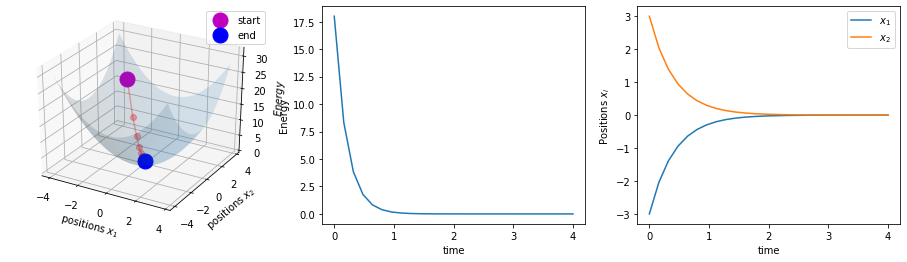

In [ ]:
# Display the results
positions = np.array(positions).squeeze() # convert to a np array
fig = plt.figure(figsize=plt.figaspect(0.25))

# Energy as a function of position and particle trajectory
ax = fig.add_subplot(1, 3, 1, projection='3d')
# Plot the Energy surface
Xmesh,Ymesh = np.meshgrid(np.arange(-4,4,.25),np.arange(-4,4,.25))
Zmesh = k*((Xmesh-o.x[0,0].numpy())**2+(Ymesh-o.x[0,1].numpy())**2) # potential energy surface
ax.plot_surface(Xmesh,Ymesh, Zmesh, alpha=0.15)
# Plot trajectory of the vertex E,x1,x2
ax.plot(positions[:,0],positions[:,1],Energies,'ro-',alpha=.3)
ax.plot(positions[:1,0],positions[:1,1],Energies[:1],'mo',ms=15,label='start')
ax.plot(positions[-1:,0],positions[-1:,1],Energies[-1:],'bo',ms=15,label='end')
ax.set_xlabel('positions $x_1$'); ax.set_ylabel('positions $x_2$'); ax.set_zlabel('$Energy$');
plt.legend();

# Energy as function of time
ax = fig.add_subplot(1, 3, 2);
ax.plot(t,Energies);
ax.set_xlabel('time'); ax.set_ylabel('Energy')

# Vertex position (components) as a function of time
ax = fig.add_subplot(1, 3, 3)
ax.plot(t,positions);
plt.legend(['$x_1$','$x_2$']);
ax.set_ylabel('Positions $x_i$'); ax.set_xlabel('time');

plt.show()

### Graph object

In [ ]:
#export
class Graph(object):
    '''Implements graph object. Stores vertices and edges. 
    - Methods:
        - `length(self)` : calculates (Euclidean) edge lengths for each edge in the graph.
        - `direction(self)`: calculates edge vectors (`second_vertex - first_vertex` positions)
        - `get_vertex_grad(self)`: returns accumulated gradients w.r.t. to vertex positions.
        - `set_zero_grad_(self)`: sets gradients w.r.t. to vertex positions to zeros.
    - Properties :
        - `vertices` : variable vertices represented by `Vertex` object (needs autograd).
        - `edges` : edges connecting vertices.Nx2 array of integers (vertex indices).
        Can be any `torch.tensor` compatible array with `tolist()` method (doesn't need autograd).
        - `fixed`: [__not yet implemented__] stores information about constant/fixed vertices (for setting boundary).
        Provided for convenience, turn off gradient calculation separately from "variable" vertices to keep them constant.
        '''
    def __init__(self,vertices=None, edges=None, fixed=None):
        '''Init-n function for `Graph` objects. Stores vertices and edges.
        
        Usage:
            `g = Graph(edges=torch.tensor([[0,1],[1,2],[2,0]]), vertices=Vertex(torch.tensor([[1,1],[0,-1],[-1,0]]))`
        ''' 
        self._vertices = vertices
        self._edges = edges
        self._fixed= fixed
    
    def length(self):
        ''' Calculates all edge lengths in the graph.
        Lengths--(Euclidean) distances between vertex pairs connected with edges.
        Order of the lengths is same as the order of the edges, i.e. i'th result corresponds to i'th edge.
        '''
        return torch.norm(self.vertices.x[self.edges[:,1],:] - self.vertices.x[self.edges[:,0],:],
                          dim=1,p=2,keepdim=True)
        
    def direction(self):
        '''Calculates edge vector (direction) from first vertex to its pair connected with an edge.'''
        return self.vertices.x[self.edges[:,1],:] - self.vertices.x[self.edges[:,0],:]
    
    def get_vertex_grad(self):
        '''Get accumulated gradients w.r.t. vertex positions (`self.vertices.x`) (calculated with backprop; `torch.autograd`)'''
        return self.vertices.grad()
    
    def set_zero_grad_(self):
        '''Set gradients to zero if `requires_grad` is set to `True` for variable vertices. Uses `vertices.zero_grad_()`'''
        self.vertices.zero_grad_()
        
    @property
    def edges(self):
        return self._edges
    @edges.setter
    def edges(self,val):
        self._edges = val
    
    @property
    def vertices(self):
        return self._vertices
    @vertices.setter
    def vertices(self, val):
        self._vertices = val
    
    @property
    def fixed(self):
        return self._fixed
    @fixed.setter
    def fixed(self, val):
        self._fixed = val
    
    def __str__(self):
        if (self.edges is None) or (self.vertices is None):
            return f"Graph: edges {self._edges}; vertices {self.vertices}"
        dtype_edges = self.edges.dtype
        dtype_verts = self.vertices.dtype()
        return f"Graph\nedges {self._edges} {dtype_edges};\nvertices {self.vertices} {dtype_verts}"
    def __repr__(self):
        n_edges = self.edges if self.edges is None else self.edges.size(0)
        n_verts = self.vertices if self.vertices is None else self.vertices.x.size(0)
        return f"Graph: {n_edges} edges; {n_verts} vertices"
    

Initializing `Graph` objects
- Provide vertices (as `Vertex` object) and edges (connected vertex indices) at initialization, or set it later with `self.vertices` and `self.edges` property setters.

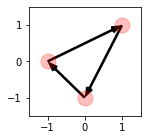

In [ ]:
g = Graph(vertices = Vertex([[1,1],[0,-1],[-1,0]], dtype=torch.float64, requires_grad=True),
          edges = torch.tensor([[0,1],[1,2],[2,0]]) )

# Plot vertex positions
plt.figure(figsize=[2,2])
plt.plot(g.vertices.x.detach()[:,0], g.vertices.x.detach()[:,1],'ro',ms=15,alpha=.25);# this plots all vertices

# plot directed edges to check them, to calculate direction use `direction()` function in Graph object
quiver_kwargs = {'units':'xy','angles':'xy','scale_units':'xy','scale':1.0,'headwidth':3,'headlength':4,'width':.07}

# here I'm detaching edge_dirs vectors (if requires_grad==True) in order to use it later with plt.quiver:
edge_dirs = g.direction().detach()

# vertices with edges:
vertices = {'x': g.vertices.x.detach()[g.edges[:,0],0], 'y': g.vertices.x.detach()[g.edges[:,0],1] }
plt.quiver(vertices['x'], vertices['y'],edge_dirs[:,0],edge_dirs[:,1],**quiver_kwargs)
plt.axis([-1.5,1.5,-1.5,1.5])
plt.show()

Evaluating functions that depend on vertex positions (edge Euclidean length, and direction functions are already implemented in `Graph` class)
- Example below illustrates how to compute spatial gradient $\frac{\partial E}{\partial x_i}$ for $E(\{x_i\})=\sum_{edges}l_{ij}^2$ for vertices shown in the graph above

In [ ]:
# do something with vertex positions
l = g.length()
E = torch.sum(l**2)

# compute gradients w.r.t. variables of y() 
E.backward()
dEdx=g.get_vertex_grad().tolist() # here I'm copying grad-s into dydv list

# reset gradients to zeros (useful for iterative calculations s.a. gradient descent)
g.set_zero_grad_()
dEdx_2=g.get_vertex_grad().tolist()
print(f'dEdx={dEdx}\n---\nafter zeroing gradients\ndEdx={dEdx_2}')

dEdx=[[6.0, 6.0], [0.0, -6.0], [-6.0, 0.0]]
---
after zeroing gradients
dEdx=[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]


In [ ]:
#export
def plot_graph(Xv,edges,plot_arg=['g-','mo'],alphas=[.2,.5]):
    '''Simple function for plotting vertices(location `Xv`) and `edges`'''
    for ij in edges:
        plt.plot([Xv[ij[0],0], Xv[ij[1],0]], [Xv[ij[0],1], Xv[ij[1],1]],plot_arg[0],lw=2,alpha=alphas[0])
    plt.plot(Xv[:,0],Xv[:,1],plot_arg[-1],ms=10,alpha=alphas[-1])
    plt.axis('equal')
    plt.axis(False);

### Graph usage example
<a name="ex2">Attracting particles in a 2D fluid</a>

Now, let's evolve in time a system decribed by a potential
$$U=k\sum_{\forall ij|j\neq i}|x_i-x_j|^2=k\sum_{\forall ij|j\neq i}l^2_{ij}$$
where every vertex $i$ is connected to all the other vertices $j$ with edges $ij$, and $x_i$ is the position of vertex $i$ on a 2D plane (vector). Force balance equation for this system, same as in [Example 1](#ex1) is 
$$b\frac{dx(t')}{dt'}=-\nabla U$$
$\nabla U$ is a function of distances between all possible pairs of vertices (edge lengths $l_{ij}$, scalars). The equation of motion for every vertex is (with $t=t'/b$)
$$\frac{dx_i}{dt}=-k\sum_{\forall ij|j\neq i}2(x_i-x_j)= 2k\sum_{\forall ij|j\neq i}(x_j-x_i)$$
This system can be described by a complete graph, `G` in the code below. In order to demonstrate how to work with this type of systems, let's create a complete graph with $N_v$ vertices.

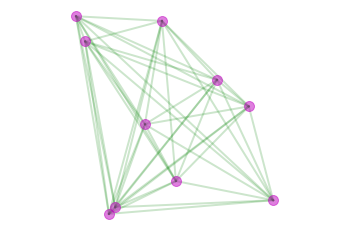

In [ ]:
np.random.seed(42) # let's seed RNG for sanity and reproducibility
Nv = 10 # number of vertices
Xv = np.random.uniform(0,1,(Nv,2)) # initial vertex potions sampled from uniform distribution [0,1)
edges = [[i,j] for i in range(Nv) for j in range(i+1,Nv) if i!=j] # list of edges for complete graph
plot_graph(Xv,edges) # plot vertices and edges

Now, let's solve $x(t)$ with Euler's method.
- Note: in the code below, `Dt` must be smaller for large $N_v$ (e.g. about $0.01$ or less for $N_v=10$, and about $0.001$ for $N_v=100$)

Number of vertices: 10 
Number of edges: 45 
Requires grad?: True
Integration (Euler's method):
t=0.001: E=2e+01; aver |dx/dt|= 8
t=0.032: E=5; aver |dx/dt|= 4
t=0.063: E=1; aver |dx/dt|= 2
t=0.095: E=0.4; aver |dx/dt|= 1
t=0.126: E=0.1; aver |dx/dt|= 0.6
t=0.157: E=0.03; aver |dx/dt|= 0.3
t=0.188: E=0.008; aver |dx/dt|= 0.2
t=0.220: E=0.002; aver |dx/dt|= 0.09


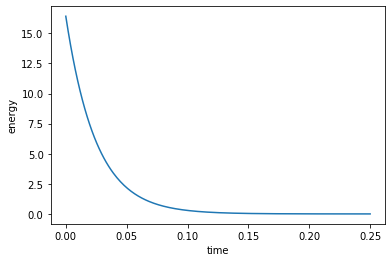

In [ ]:
# initialize a graph
G = Graph(vertices=Vertex(torch.from_numpy(Xv).clone(),requires_grad=True, dtype=torch.float64), edges=torch.tensor(edges) )
G.vertices.requires_grad_(True) # turn on `Vertex` gradients; check its status with G.vertices.requires_grad()
print('Number of vertices:',G.vertices.x.size(0),'\nNumber of edges:', G.edges.size(0),
      '\nRequires grad?:',G.vertices.requires_grad())

# Define energy function
k=1.0
energy = lambda l: k*torch.sum(l**2) # E = k sum(l_ij ^2)
# Numerical integration
Dt = 2**-10 # time step size
positions = [G.vertices.x.clone()]
t = [0]
Energies = []
print('Integration (Euler\'s method):')
for n in range(256):
    G.set_zero_grad_() # reset grad accumulator
    E = energy(G.length())  # total potential energy of the system
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -G.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        G.vertices.x += dxdt*Dt
    positions.append(G.vertices.x.clone())
    t.append(t[-1]+Dt)
    if n%32==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():1.1g}; aver |dx/dt|= {mean_grad:1.1g}')
Energies.append( energy(G.length()).item() )
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');

Results for numerical integration above as a movie of the graph $G$:

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

# set up figure, axis, and artists
fig, ax = plt.subplots()
xy_min = min(0.0,positions[0].min().item())
xy_max = max(1.0,positions[0].max().item())
ax.axis('square')
ax.axis([xy_min,xy_max,xy_min,xy_max]);ax.axis(False)
edge_lines = []
for ij in G.edges:
    edge_line, = ax.plot([], [],'g-', lw=2,alpha=.2)
    edge_lines.append(edge_line)
node_dots, = ax.plot([], [], 'mo',ms=10,alpha=.5)

# use matplotlib's animation.FuncAnimation
def init():
    ax.set_title(f"{t[0]:4.3f}")
    for edge_line in edge_lines:
        edge_line.set_data([], [])
    node_dots.set_data([], [])
    return (*edge_lines,node_dots)

def animate(i):
    ax.set_title(f"t={t[i]:4.3f}")
    xy = positions[i].detach().numpy()
    for k,edge_line in enumerate(edge_lines):
        ij = G.edges[k,:].numpy()
        edge_line.set_data([xy[ij[0],0],xy[ij[1],0]], [xy[ij[0],1],xy[ij[1],1]])
    node_dots.set_data(xy[:,0], xy[:,1])
    return (*edge_lines,node_dots)

f_anim = animation.FuncAnimation(fig, animate, init_func=init, interval=200,
                                 frames = range(0,len(positions),max(1,round(len(positions)/64))))
plt.close()

HTML(f_anim.to_jshtml()) # using HTML from IPython.display and matplotlib's animation module

## Cell monolayer representations

### Monolayer object

In [ ]:
#export
class Monolayer(Graph):
    '''Implements 2-dimensional cell monolayer (apical plane) represented by vertices and edges.
    
    - to-do:
        - add cell perimeter and cell area calculation methods
    '''
    def __init__(self, vertices=None, edges=None, cells=None, fixed=None):
        '''Usage:
        - cells = Monolayer(edges=torch.tensor([[0,1],[1,2],[2,0]]), vertices=Vertex([[1.,1.],[0.,-1.],[-1.,0.]]))
        '''
        super().__init__(vertices=vertices, edges=edges, fixed=fixed)
        
        # cells must be a dict (keys:cell#,values:edge indices w/ negative indices for reverced edge direction)
        self._cells = cells 
        
    def perimeter(self):
        '''Calculates perimeters of the cells'''
        if (self.cells is None) or len(self.cells)==0:
            return torch.zeros((1,))
        Perims = []
        for c in self.cells:
            c_edges = self.edges[np.abs(self.cells[c])-1,:]
            Perims.append(torch.sum(torch.norm(
                self.vertices.x[c_edges[:,1],:] - self.vertices.x[c_edges[:,0],:],
                dim=1,p=2,keepdim=True),0,keepdim=True))
        return torch.cat(Perims,dim=0)
    
    def area(self):
        '''Calculates areas of the cells'''
        if (self.cells is None) or len(self.cells)==0:
            return torch.zeros((1,))
        Areas = []
        for c in self.cells:
            # compute area of each cell
            Areas.append()
        return torch.cat(Areas,dim=0)
    
    @property
    def cells(self):
        return self._cells
    @cells.setter
    def cells(self, val):
        self._cells = val
    
    def __str__(self):
        n_cells = self.cells if self.cells is None else len(self.cells)
        return f"Monolayer {n_cells} cells\n{self.cells};\n{super().__str__()}"
    def __repr__(self):
        n_cells = self.cells if self.cells is None else len(self.cells)
        return f"Monolayer {n_cells} cells, {super().__repr__()}"

### Helper functions

In [ ]:
#export
def VoronoiRegions2Edges(regions):
    '''Converts Voronoi region vertex indices, like the one obtained from `scipy.spatial.Voronoi`, 
    to a list of (*undirected*) edges (indices of vertex pairs).
    
    Edges [i,j] and [j,i] are considered to be the same edge, and stored as one of these 
    representations e.g. [j,i], but not both (i.e. no duplicate edges). Note that edge indexing in
    `cells` starts from 1 (not 0!). Thus, when reading cell edges from `edge_list` you need to 
    substract 1 from (absolute value of) these indices. E.g.
    ```python
    vrn = Voronoi(seeds) # <-- scipy.spatial.Voronoi
    edge_list,cells = VoronoiRegions2Edges(vrn.regions)
    edges = np.array(edge_list)
    # select cell 0 edges:
    cell_edges = edges[np.abs(cells[0])-1,:] # subtract 1 from indices to covert to start from 0
    ```
    
    Arg-s:
    - `regions` is a list of lists, empty regions, or regions with out-of-diagram vertices ("-1") are ignored
    
    Returns:
    - `edge_list` : list of edges of an undirected graph.
    - `cells`: dictionary of cells (Voronoi regions), keys: cell numbers, values: list of 
    **edge indices starting from 1**. Negative indices indicate reversed order for vertices 
    (together these edges form a closed region--a cell). Use `np.sign(cells[c])` to find reversed edges.
    '''
    def is_in_edges_(e,edge_list):
        '''Returns edge index in the list, "-" means in reversed order, False if not found'''
        if (e in edge_list):
            return edge_list.index(e)+1
        elif ((e[1],e[0]) in edge_list):
            return -(1+edge_list.index((e[1],e[0])))
        else:
            return False
    
    edge_list = []
    cells = {}
    cell_k = 0
    for r in regions:
        if len(r)==0 or (-1 in r ):
            continue # ignore empty regions or those with vertex index -1
        cells[cell_k] = []
        for e in zip(r[-1:]+r[:-1],r):
            edge_idx = is_in_edges_(e,edge_list)
            if edge_idx:
                cells[cell_k].append(edge_idx)
            else:
                cells[cell_k].append(len(edge_list)+1)
                edge_list.append(e)
        cell_k+=1
    return edge_list,cells

Seeds for Voronoi tessellation:

In [ ]:
v_seeds=np.array([[np.sqrt(3)/2,5.5], [1.5*np.sqrt(3),5.5], [0.,4.], [np.sqrt(3),4.], [2*np.sqrt(3),4.],
                  [-np.sqrt(3)/2,2.5],[np.sqrt(3)/2,2.5],[1.5*np.sqrt(3),2.5],[2.5*np.sqrt(3),2.5],
                  [0.,1.],[2*np.sqrt(3),1.], [np.sqrt(3),1.]])

After obtaining the Voronoi tesselation, use `VoronoiRegions2Edges` to convert regions into a `Monolayer` (and `Graph`) compatible edges and cells representations:

In [ ]:
from scipy.spatial import Voronoi,voronoi_plot_2d
vrn = Voronoi(v_seeds)

edge_list,cells = VoronoiRegions2Edges(vrn.regions) # convert regions to edges and cells
print(cells)

{0: [1, 2, 3, 4, 5, 6], 1: [-3, 7, 8, 9, 10, 11], 2: [-2, 12, 13, 14, 15, -7]}


`cells` is the `dict` of edge indices. Negative edge indices indicate reversed vertex order:

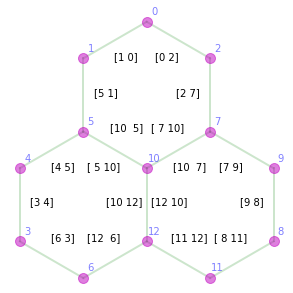

In [ ]:
verts = Vertex(vrn.vertices)
edges = torch.tensor(edge_list)

plt.figure(figsize=[5,5])
plot_graph(verts.x,edges)

# vertex indices
for k,v in enumerate(vrn.vertices):
    plt.text(v[0]+.1,v[1]+.1,f"{k}",c='b',ha='center',alpha=.5)

# cell edges
for c in cells:
    cell_edges = edges[np.abs(cells[c])-1,:] # edge indices (without direction)
    if np.any(np.sign(cells[c])<0):
        # reverse vertex order for negative edges
        tmp = cell_edges[np.sign(cells[c])<0,:].clone()
        cell_edges[np.sign(cells[c])<0,0]=tmp[:,1]
        cell_edges[np.sign(cells[c])<0,1]=tmp[:,0]
    cell_xy = torch.mean(verts.x[cell_edges[:,0],:],0)
    for e in cell_edges:
        e_xy = torch.mean(verts.x[e,:],0)*.65+cell_xy*.35
        plt.text(e_xy[0],e_xy[1],f"{e.numpy()}",ha='center')
plt.show()

### Monolayer example

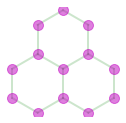

Integration (Euler's method):
t=0.062: E=4e+01; aver |dx/dt|= 7


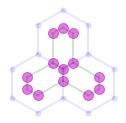

t=0.125: E=1e+01; aver |dx/dt|= 4


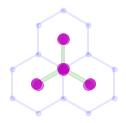

t=0.188: E=9; aver |dx/dt|= 3


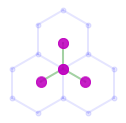

t=0.250: E=7; aver |dx/dt|= 6


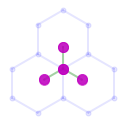

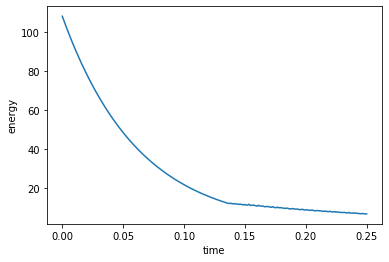

In [ ]:
# using Voronoi tesselation from above:
verts = Vertex(vrn.vertices)
edges = torch.tensor(edge_list)

cell_graph = Monolayer(vertices=Vertex(vrn.vertices.copy()), edges=edges, cells=cells)
cell_graph.vertices.requires_grad_(True)

# initial state
figsize=[2,2]
plt.figure(figsize=figsize)
plot_graph(vrn.vertices,cell_graph.edges)
axs_lims = plt.axis()
plt.show()

# Define energy function
k=1.0
energy = lambda p: torch.sum((p)**2) #
# Numerical integration
Dt = 2**-10 # time step size
t = [0]
Energies = []
print('Integration (Euler\'s method):')
t_total = 256
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    E = energy(cell_graph.perimeter())  # total potential energy of the system
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
    t.append(t[-1]+Dt)
    if round((n+1)%(t_total/4))==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():1.1g}; aver |dx/dt|= {mean_grad:1.1g}')
        plt.figure(figsize=figsize)
        plot_graph(vrn.vertices,cell_graph.edges,plot_arg=['b-','b.'],alphas=[.1])
        plot_graph(cell_graph.vertices.x.detach(),cell_graph.edges)
        plt.axis(axs_lims)
        plt.show()
Energies.append( energy(cell_graph.perimeter()).item() )
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');

For `voron = Voronoi(verts.x)`:
- `voron.vertices` (cell) vertices 
- `voron.regions` "edges", with "-1" indicating vertex outside the Voronoi diagram
- end of [this](https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/spatial.html#qhulltutorial) has notes on how to plot "-1" vertices:
    - vertices inside the diagram:
    ```python
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            plt.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k-')
    ```
    - vertices outside: 
    ```python
    center = points.mean(axis=0)
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.any(simplex < 0):
            i = simplex[simplex >= 0][0] # finite end Voronoi vertex
            t = points[pointidx[1]] - points[pointidx[0]]  # tangent
            t = t / np.linalg.norm(t)
            n = np.array([-t[1], t[0]]) # normal
            midpoint = points[pointidx].mean(axis=0)
            far_point = vor.vertices[i] + np.sign(np.dot(midpoint - center, n)) * n * 100
            plt.plot([vor.vertices[i,0],far_point[0]], [vor.vertices[i,1],far_point[1]],'k--')
    ```
    


- to-do:
    - plotting functions for monolayers
    - add area using ["shoelace formula"](https://en.wikipedia.org/wiki/Shoelace_formula) another [link](https://www.mathopenref.com/coordpolygonarea.html) 

In [ ]:
#hide
# from scipy.spatial import Delaunay
# # convex shapes are easier to divide into regions:
# # - potentially can use Delaunay triangulation
# #
# # verts for haxagon:
# verts=Vertex([[np.sqrt(3),0.], [0.,1.],   [0.,3.], 
#               [np.sqrt(3),4.], [2*np.sqrt(3),3.], [2*np.sqrt(3),1.],
#               [np.sqrt(3),1.], [np.sqrt(3)/2,1.5], [np.sqrt(3)/2,2.5],
#               [np.sqrt(3),3.],[1.5*np.sqrt(3),2.5],[1.5*np.sqrt(3),1.5]
#              ])
# edges=torch.tensor([[0,6],[6,7],[7,8],[8,9],[9,10],[10,11],[6,11],[1,7],[2,8],[3,9],[4,10],[5,11]])

# tri = Delaunay(verts.x)

# plt.figure(figsize=[7,3])
# plt.subplot(121)
# # plot edges and vertices
# for e in edges:
#     plt.plot(verts.x[e,0],verts.x[e,1],'g--',alpha=.8)
# plt.plot(verts.x[:,0],verts.x[:,1],'mo',ms=10,alpha=.3)

# # label the points
# for j, p in enumerate(verts.x):
#     plt.text(p[0]-0.04, p[1]+0.04, j, ha='right') 
# # plot triangles
# plt.triplot(verts.x[:,0],verts.x[:,1], tri.simplices.copy(),alpha=.2,lw=5)
# for j, s in enumerate(tri.simplices):
#     p = verts.x[s,:].mean(axis=0)
#     plt.text(p[0], p[1], '#%d' % j, ha='center',alpha=.3) # label triangles
# plt.axis('equal');

# # Concave shapes are more challenging to segment into regions of cells
# # - maybe need to use constrained Delaunay
# # deformed hexagon
# verts=Vertex([[np.sqrt(3),0.], [0.,1.],   [0.,3.], 
#               [np.sqrt(3),4.], [2*np.sqrt(3),3.], [2*np.sqrt(3),1.],
#               [np.sqrt(3),1.], [np.sqrt(3)/2,1.5], [np.sqrt(3)/2,2.5],
#               [np.sqrt(3),3.],[1.5*np.sqrt(3),2.5],[np.sqrt(2),2.1]
#              ])

# tri = Delaunay(verts.x)
# plt.subplot(122)
# for e in edges:
#     plt.plot(verts.x[e,0],verts.x[e,1],'g--')
# plt.plot(verts.x[:,0],verts.x[:,1],'mo',ms=10,alpha=.3)

# plt.triplot(verts.x[:,0],verts.x[:,1], tri.simplices.copy(),alpha=.2,lw=5)
# for j, s in enumerate(tri.simplices):
#     p = verts.x[s,:].mean(axis=0)
#     plt.text(p[0], p[1], '#%d' % j, ha='center',alpha=.3) # label triangles

# for j, p in enumerate(verts.x):
#     plt.text(p[0]-0.04, p[1]+0.04, j, ha='right') # label the points
    
# plt.axis('equal');

In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted index.ipynb.
